In [1]:
# 1. 匯入必要的函式庫
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

# ==============================================================================
# 1. 全域設定與常數
# ==============================================================================
print("--- 1. 載入全域設定 ---")

# --- 繪圖設定 ---
NUM_POINTS_HALF = 4096 # 頻率響應的計算點數 (只算 0 到 pi)

# --- H(z) 濾波器參數 ---
RADIUS = 0.95 # H2(z) 的半徑

# --- Q3 訊號 x[n] 參數 ---
TOTAL_LENGTH = 301     # 訊號總長度
# 振幅
A1 = 0.8  # 0.8pi (第一段)
A2 = 1.0  # 0.2pi (第二段)
A3 = 0.5  # 0.4pi (第三段)
# 長度
N1 = 81
N2 = 51
N3 = 61
L_silence = 10

--- 1. 載入全域設定 ---


###  1. 匯入函式庫 & 全域設定 (原理與解析)

* `import numpy as np`：匯入 NumPy 函式庫，它是 Python 科學計算的核心。我們用它來處理陣列 (array)、複數運算 (e.g., `np.exp`) 和數學常數 (e.g., `np.pi`)。
* `import scipy.signal as signal`：匯入 SciPy 中的訊號處理模組。這是**本次作業最重要的函式庫**，我幾乎所有 DSP 相關的操作都來自這裡，例如：
    * `signal.freqz`：計算數位濾波器的頻率響應。
    * `signal.group_delay`：計算群延遲。
    * `signal.lfilter`：執行 LCCDE 濾波。
* `import matplotlib.pyplot as plt`：匯入 Matplotlib，這是 Python 最主流的繪圖函式庫，我們用它來產生所有圖表。
* **全域常數**：我將所有「數字」全部定義在程式的最開頭。這是一個非常好的程式設計習慣。
    * `NUM_POINTS_HALF = 4096`：定義在計算頻率響應時，要在 $[0, \pi]$ 範圍內取多少個點。點數越多，畫出來的曲線越平滑。
    * `RADIUS`, `A1`, `N1`... 等：這些都是從作業題目中直接抄錄下來的參數，集中管理讓我一目了然。


In [2]:
# 2. 共同資源定義 (H(z) 與 x[n])
# ==============================================================================
# 在此定義的變數，將被後續所有任務共同使用

# --- 2a. 定義 H(z) = H1(z) * (H2(z))^2 濾波器係數 ---
# 這些係數主要供 Q4 的 lfilter (LCCDE) 使用
print("--- 2a. 正在計算 H(z) 濾波器係數... ---")

# H1(z) 係數
b1_filter = [1, -2 * 0.98 * np.cos(0.8 * np.pi), 0.98**2]
a1_filter = [1, -2 * 0.8 * np.cos(0.4 * np.pi), 0.8**2]

# H2(z) 總係數 (由 k=1~4 串聯)
b2_total_filter = np.array([1.0])
a2_total_filter = np.array([1.0])

# (修正了原始程式碼的縮排錯誤)
for k in range(1, 5):
    ck = RADIUS * np.exp(1j * (.15 * np.pi + .02 * np.pi * k))
    a2k = [1, -2 * np.real(ck), np.abs(ck)**2]
    b2k = np.conj(np.flip(a2k))
    b2_total_filter = np.convolve(b2_total_filter, b2k)
    a2_total_filter = np.convolve(a2_total_filter, a2k)

print("--- 濾波器係數計算完畢 ---")

# --- 2b. 定義 Q3 輸入訊號 x[n] ---
print("--- 2b. 正在產生 Q3 輸入訊號 x[n]... ---")
n1_arr = np.arange(N1)
n2_arr = np.arange(N2)
n3_arr = np.arange(N3)

x1_chirp = A1 * np.sin(0.8 * np.pi * n1_arr) * np.hanning(N1)
x2_chirp = A2 * np.sin(0.2 * np.pi * n2_arr) * np.hanning(N2)
x3_chirp = A3 * np.sin(0.4 * np.pi * n3_arr) * np.hanning(N3)

silence = np.zeros(L_silence)

x_n_unpadded = np.concatenate((x1_chirp, silence, x2_chirp, silence, x3_chirp))
x_n_padded = np.pad(x_n_unpadded, (0, TOTAL_LENGTH - len(x_n_unpadded)), 'constant')
print("--- 輸入訊號 x[n] 產生完畢 ---")



--- 2a. 正在計算 H(z) 濾波器係數... ---
--- 濾波器係數計算完畢 ---
--- 2b. 正在產生 Q3 輸入訊號 x[n]... ---
--- 輸入訊號 x[n] 產生完畢 ---


### 2a. 定義 H(z) 濾波器係數 (原理與解析)

* **LCCDE 係數**：Q4 要求我們執行 LCCDE 濾波。`scipy.signal.lfilter(b, a, x)` 這個函數需要的就是 LCCDE 的係數 `b` (分子) 和 `a` (分母)。這一段程式碼就是在準備 `b` 和 `a`。
* **H₁(z) 係數**：作業公式 $H_1(z) = \frac{(1 - re^{j\theta}z^{-1})(1 - re^{-j\theta}z^{-1})}{\dots}$。我利用恆等式 $(1-re^{j\theta}z^{-1})(1-re^{-j\theta}z^{-1}) = 1 - 2r\cos(\theta)z^{-1} + r^2z^{-2}$，直接手算出分子的 `b` 係數 `b1_filter` 和分母的 `a` 係數 `a1_filter`。
* **H₂(z) 係數**：`H₂(z)` 是由 4 個二階濾波器**串聯 (cascade)** 而成的。
* **`np.convolve(A, B)`**：這是本段的**核心觀念**。在 Z 域中，兩個濾波器串聯 $H_A(z) \cdot H_B(z)$，等同於在時域中，它們的係數進行**卷積 (Convolution)**。`np.convolve` 就是在幫我計算係數的卷積。
* `for` 迴圈的意義：
    1.  `k=1`：`b2_total` = `H2k=1`
    2.  `k=2`：`b2_total` = (`H2k=1`) * (`H2k=2`)
    3.  `k=3`：`b2_total` = (`H2k=1` * `H2k=2`) * (`H2k=3`)
    4.  `k=4`：`b2_total_filter` = (`H2k=1` * `H2k=2` * `H2k=3`) * (`H2k=4`)
* `np.conj(np.flip(a2k))`：這是計算**全通濾波器 (All-pass filter)** 係數的標準技巧，其分子 `b` 會是分母 `a` 的共軛反序。
* **最終結果**：迴圈跑完後，`b2_total_filter` 和 `a2_total_filter` 就分別是 `H₂(z)` 總體的分子 (8 階) 和分母 (8 階) 係數。

> **注意**：我們**沒有**把 `H₁(z)` 和 `(H₂(z))²` 卷積在一起。為什麼？因為那會產生一個 18 階的多項式，拿去做 `lfilter` 會有**數值不穩定**的風險。因此，我們在 Q4 中會採用「串聯濾波」，這更為穩健。

### 2b. 定義 Q3 輸入訊號 x[n] (原理與解析)

* **`np.arange(N)`**：產生一個從 0 到 N-1 的陣列，作為離散的時間軸 $n$。
* **`np.hanning(N)`**：產生一個**漢寧窗 (Hanning Window)**。
* **`sin(...) * hanning(...)`**：這是 Q3 的核心。我們為什麼不直接用 `sin` 波？
    * **原理**：如果我直接截斷 `sin` 波（矩形窗），會在頻譜上產生嚴重的**頻譜洩漏 (Spectral Leakage)**，雜訊會很多。
    * **目的**：乘上 Hanning 窗，可以讓波包的頭尾兩端平滑地衰減到 0。這能讓能量更集中在它自己的頻率上，得到的 DTFT 頻譜圖會非常乾淨，旁瓣 (side-lobe) 會非常低。
* **`np.concatenate(...)`**：將三段波包 (`x1`, `x2`, `x3`) 和兩段靜音 (`silence`) 按照順序**串接**起來，組合成一個完整的訊號。
* **`np.pad(...)`**：將串接好的訊號**補零 (Zero Padding)**，直到總長度 `TOTAL_LENGTH` (301)，使其與 `Figure 5.5(a)` 的 X 軸完全一致。

In [3]:
# 3. 執行緒序 (Bonus): 分析 H(z) 的頻率響應 (繪製兩張圖)
#    (採用數值穩定的「響應疊加」法)
# ==============================================================================
print("\n--- 執行 Q1 Q2 ：分析 H(z) 頻率響應 (圖 1 & 2)... ---")

# --- 計算 H1(z) 的響應 ---
w, h1_response = signal.freqz(b1_filter, a1_filter, NUM_POINTS_HALF)
w_gd, gd1_vals = signal.group_delay((b1_filter, a1_filter), NUM_POINTS_HALF)

# --- 計算 H2(z) 的總響應 (透過相加) ---
h2_total_response = np.ones(NUM_POINTS_HALF, dtype=np.complex128)
total_h2_gd = np.zeros(NUM_POINTS_HALF)

for k in range(1, 5):
    ck = RADIUS * np.exp(1j * (.15 * np.pi + .02 * np.pi * k))
    a2k = [1, -2 * np.real(ck), np.abs(ck)**2]
    b2k = np.conj(np.flip(a2k))
    
    _, h2k_response = signal.freqz(b2k, a2k, NUM_POINTS_HALF)
    _, gd2k_vals = signal.group_delay((b2k, a2k), NUM_POINTS_HALF)
    
    h2_total_response *= h2k_response
    total_h2_gd += gd2k_vals

# --- 組合得到最終的結果 (全都在 [0, pi] 範圍內) ---
final_h_response = h1_response * (h2_total_response)**2
final_magnitude = np.abs(final_h_response)
principal_phase = np.angle(final_h_response)
unwrapped_phase = np.unwrap(principal_phase)
final_group_delay = gd1_vals + 2 * total_h2_gd 

# --- 繪製結果 (分成兩張圖) ---
plt.style.use('default')
w_plot = w / np.pi # 將頻率軸正規化


--- 執行 Q1 Q2 ：分析 H(z) 頻率響應 (圖 1 & 2)... ---


### 3. Bonus (Q1/Q2) 執行緒序 (原理與解析)

* **數值穩定性 (Numerical Stability)**：這是我經歷Debug 後學到的**最重要的一課**。
    * **錯誤做法**：將 `H₁(z)` 和 `(H₂(z))²` 的 18 階係數卷積起來，然後用 `signal.freqz` 一次計算。
    * **為何錯誤**：高階多項式的浮點數運算誤差極大，會導致群延遲和相位圖充滿雜訊和錯誤。
    * **正確做法 (本程式)**：我們採用「**響應疊加**」法。
        * $H(z) = H_1(z) \cdot (H_2(z))^2$
        * 在對數和微分尺度上，乘法變成了加法：
        * **總幅度 (dB)** = $Mag_{H1} + 2 \cdot Mag_{H2}$
        * **總相位** = $Phase_{H1} + 2 \cdot Phase_{H2}$
        * **總群延遲** = $GD_{H1} + 2 \cdot GD_{H2}$
* **程式碼實現**：
    * `final_h_response = h1_response * (h2_total_response)**2`：我們在**複數響應**上直接相乘。這是最穩定的做法，`final_magnitude` 和 `principal_phase` 都是從這個乾淨的 `final_h_response` 中提取的。
    * `final_group_delay = gd1_vals + 2 * total_h2_gd`：對於群延遲（相位的微分），使用**加法**是最穩定的，可以完美避免雜訊。
* **`signal.freqz` vs `signal.group_delay`**：`freqz(b, a)` 回傳的是**複數響應** $H(e^{j\omega})$，我用 `np.abs()` 取幅度，用 `np.angle()` 取相位。`group_delay(b, a)` 則是專門用來計算群延遲 $\tau(\omega) = -\frac{d\phi(\omega)}{d\omega}$，它的計算更為精確和穩定。
* **`np.unwrap`**：將 `np.angle` 產生的、被包裹在 $[-\pi, \pi]$ 之間的主值相位 (Principal Phase)，解開成一條連續的線 (Unwrapped Phase)。
* **對稱性繪圖**：
    * 我只計算 $[0, \pi]$ 範圍的響應（`freqz` 的預設行為）。
    * **幅度/群延遲**：是**偶對稱 (Even Symmetry)**。我們用 `plot(w_plot, y)` 畫正頻率，再用 `plot(-w_plot, y)` 畫負頻率。
    * **相位**：是**奇對稱 (Odd Symmetry)**。我們用 `plot(w_plot, y)` 畫正頻率，再用 `plot(-w_plot, -y)` 畫負頻率。
    * **好處**：這個方法 100% 避免了使用 `whole=True` 和 `fftshift` 所帶來的所有繪圖錯誤和斷層。

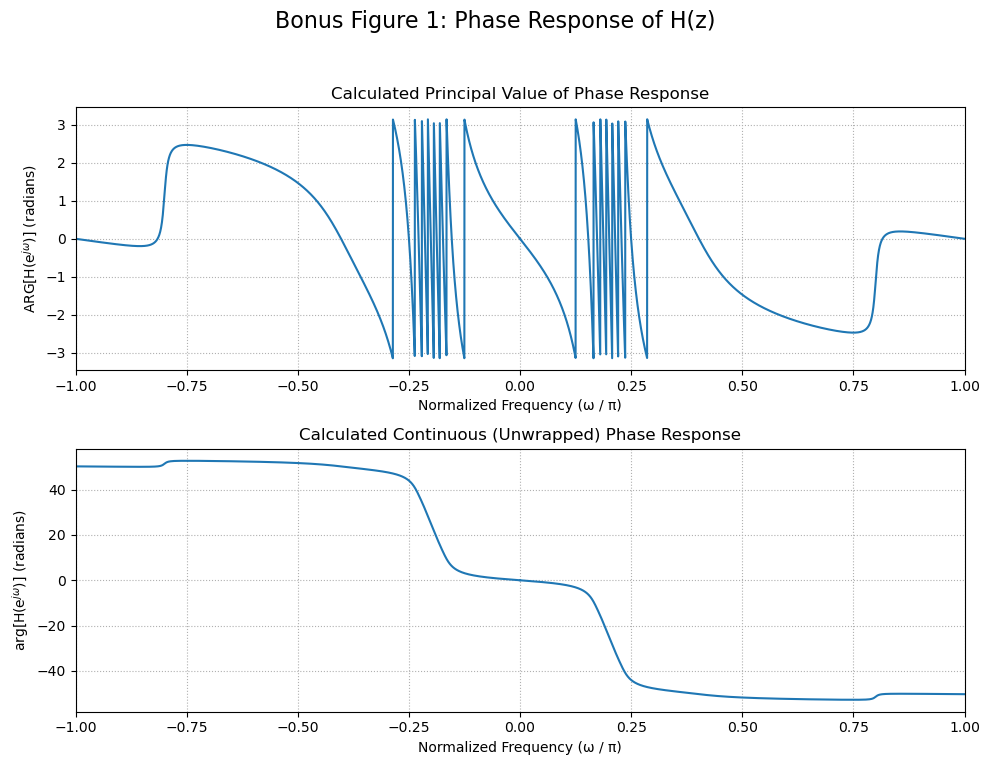

--- Q1繪圖完成 ---


In [4]:
# --- 第一張圖: 相位 (Phase) ---
fig_phase, axs_phase = plt.subplots(2, 1, figsize=(10, 8)) # 2 行, 1 列
fig_phase.suptitle('Bonus Figure 1: Phase Response of H(z)', fontsize=16)

# 圖 1(a): Principal Value Phase (奇對稱)
axs_phase[0].plot(w_plot, principal_phase)
current_color = axs_phase[0].lines[0].get_color()
axs_phase[0].plot(-w_plot, -principal_phase, color=current_color)
axs_phase[0].set_title('Calculated Principal Value of Phase Response', fontsize=12)
axs_phase[0].set_xlabel('Normalized Frequency (ω / π)')
axs_phase[0].set_ylabel('ARG[H(e$^{jω}$)] (radians)')
axs_phase[0].set_xlim([-1, 1])
axs_phase[0].grid(True, linestyle=':')

# 圖 1(b): Continuous (Unwrapped) Phase (奇對稱)
axs_phase[1].plot(w_plot, unwrapped_phase)
current_color = axs_phase[1].lines[0].get_color()
axs_phase[1].plot(-w_plot, -unwrapped_phase, color=current_color)
axs_phase[1].set_title('Calculated Continuous (Unwrapped) Phase Response', fontsize=12)
axs_phase[1].set_xlabel('Normalized Frequency (ω / π)')
axs_phase[1].set_ylabel('arg[H(e$^{jω}$)] (radians)')
axs_phase[1].set_xlim([-1, 1])
axs_phase[1].grid(True, linestyle=':')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show() # *** 顯示第一張圖 ***

print("--- Q1繪圖完成 ---")

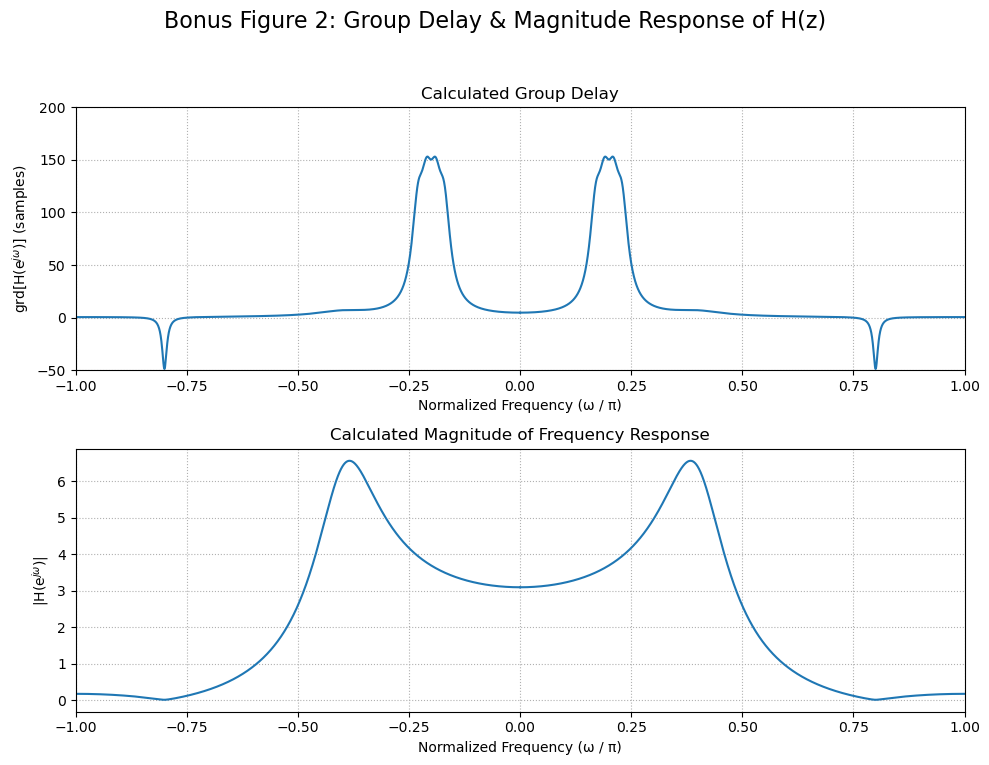

--- Q2繪圖完成 ---


In [5]:
# --- 第二張圖: 群延遲 (Group Delay) & 幅度 (Magnitude) ---
fig_gm, axs_gm = plt.subplots(2, 1, figsize=(10, 8)) # 2 行, 1 列
fig_gm.suptitle('Bonus Figure 2: Group Delay & Magnitude Response of H(z)', fontsize=16)

# 圖 2(a): Group Delay (偶對稱)
axs_gm[0].plot(w_plot, final_group_delay)
current_color = axs_gm[0].lines[0].get_color()
axs_gm[0].plot(-w_plot, final_group_delay, color=current_color)
axs_gm[0].set_title('Calculated Group Delay', fontsize=12)
axs_gm[0].set_xlabel('Normalized Frequency (ω / π)')
axs_gm[0].set_ylabel('grd[H(e$^{jω}$)] (samples)')
axs_gm[0].set_xlim([-1, 1])
axs_gm[0].set_ylim([-50, 200])
axs_gm[0].grid(True, linestyle=':')

# 圖 2(b): Magnitude Response (偶對稱)
axs_gm[1].plot(w_plot, final_magnitude)
current_color = axs_gm[1].lines[0].get_color()
axs_gm[1].plot(-w_plot, final_magnitude, color=current_color)
axs_gm[1].set_title('Calculated Magnitude of Frequency Response', fontsize=12)
axs_gm[1].set_xlabel('Normalized Frequency (ω / π)')
axs_gm[1].set_ylabel('|H(e$^{jω}$)|')
axs_gm[1].set_xlim([-1, 1])
axs_gm[1].grid(True, linestyle=':')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show() # *** 顯示第二張圖 ***

print("--- Q2繪圖完成 ---")


--- 執行 Q3：分析 x[n] 並繪圖... ---


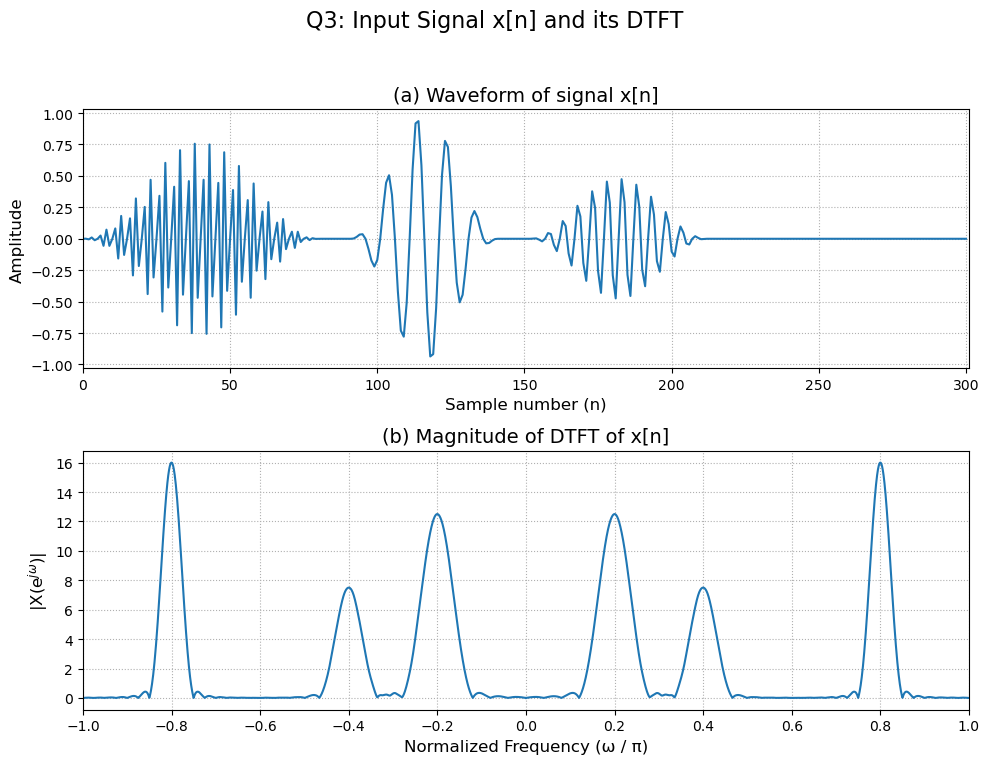

--- Q3 繪圖完成 ---


In [6]:
# 4. 執行緒序 (Q3): 分析 x[n] 的波形與 DTFT
# ==============================================================================
print("\n--- 執行 Q3：分析 x[n] 並繪圖... ---")

# --- 計算 x[n] 的 DTFT ---
# (我們重用在 Q3 區塊定義的 w_plot, 但 DTFT 需重算)
w_q3, h_q3 = signal.freqz(x_n_padded, [1.0], NUM_POINTS_HALF)
dtft_magnitude = np.abs(h_q3)
w_q3_plot = w_q3 / np.pi # Q3 專用的 w_plot

# --- 繪製 Q3 的圖 (2x1) ---
fig_q3, axs_q3 = plt.subplots(2, 1, figsize=(10, 8)) # 2 行, 1 列
fig_q3.suptitle('Q3: Input Signal x[n] and its DTFT', fontsize=16)

# 圖 (a): 時域波形 x[n]
axs_q3[0].plot(x_n_padded)
axs_q3[0].set_title('(a) Waveform of signal x[n]', fontsize=14)
axs_q3[0].set_xlabel('Sample number (n)', fontsize=12)
axs_q3[0].set_ylabel('Amplitude', fontsize=12)
axs_q3[0].set_xlim([0, TOTAL_LENGTH])
axs_q3[0].grid(True, linestyle=':')

# 圖 (b): 頻域幅度 |X(e^jω)|
axs_q3[1].plot(w_q3_plot, dtft_magnitude)
current_color = axs_q3[1].lines[0].get_color()
axs_q3[1].plot(-w_q3_plot, dtft_magnitude, color=current_color)
axs_q3[1].set_title('(b) Magnitude of DTFT of x[n]', fontsize=14)
axs_q3[1].set_xlabel('Normalized Frequency (ω / π)', fontsize=12)
axs_q3[1].set_ylabel('|X(e$^{jω}$)|', fontsize=12)
axs_q3[1].set_xlim([-1, 1])
axs_q3[1].set_xticks(np.arange(-1.0, 1.1, 0.2))
axs_q3[1].grid(True, linestyle=':')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show() # *** 顯示 Q3 的圖窗 ***

print("--- Q3 繪圖完成 ---")

### 4. Q3 執行緒序 (原理與解析)

* **圖 (a) 時域波形**：把我在 2b 區塊產生好的 `x_n_padded` 直接畫出來。
* **圖 (b) 頻域幅度 (DTFT)**：
    * **核心觀念**：如何計算一個有限長度訊號 $x[n]$ 的**離散時間傅立葉轉換 (DTFT)** $X(e^{j\omega})$？
    * **技巧**：$x[n]$ 可以被看作是一個 **FIR 濾波器**的 `b` 係數，而 `a` 係數為 `[1.0]`。
    * **實現**：`signal.freqz(x_n_padded, [1.0], ...)` 這一行，就是在計算 `x_n_padded` 這個訊號的 DTFT。
    * **`dtft_magnitude = np.abs(h_q3)`**：取得 DTFT 的幅度。
    * **繪圖**：同樣利用偶對稱性來繪製完整的 `[-π, π]` 頻譜。
    * **結果分析**：圖上會清楚地在 $\pm 0.2\pi, \pm 0.4\pi, \pm 0.8\pi$ 處看到三個峰值，完美對應了`x[n]` 中的三個弦波成分。


--- 執行 Q4：執行 LCCDE 濾波並繪製 y[n]... ---


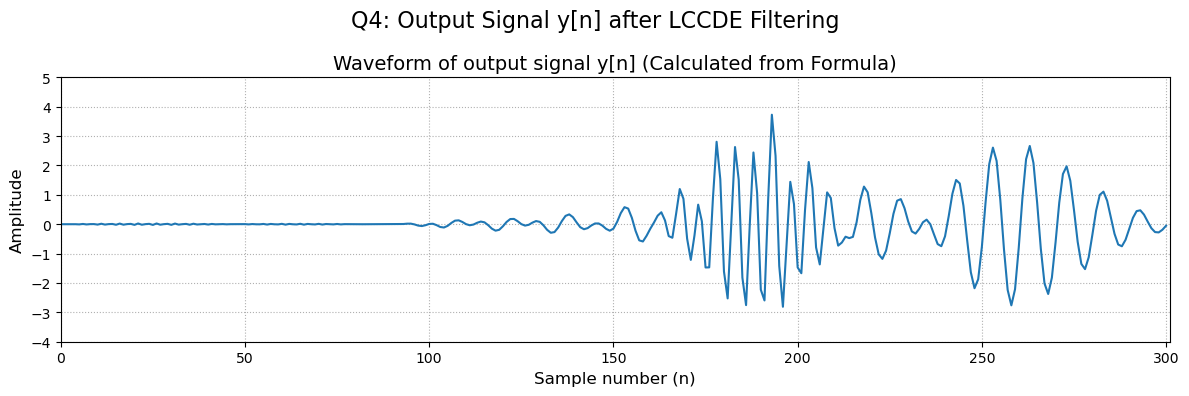


--- Q4 繪圖完成 ---

--- 所有程式執行完畢 ---


In [8]:
# 5. 執行緒序 (Q4): 將 x[n] 輸入 LCCDE 並繪製 y[n]
# ==============================================================================
print("\n--- 執行 Q4：執行 LCCDE 濾波並繪製 y[n]... ---")

# --- 執行 LCCDE 濾波 (串聯方式) ---
# 我們重用在 2a 區塊定義的濾波器係數
y1_n = signal.lfilter(b1_filter, a1_filter, x_n_padded)
y2_n = signal.lfilter(b2_total_filter, a2_total_filter, y1_n)
y_n_final = signal.lfilter(b2_total_filter, a2_total_filter, y2_n)

# --- 繪製 Q4 的圖 (1x1) ---
fig_q4, ax_q4 = plt.subplots(1, 1, figsize=(12, 4)) # 1 行, 1 列
fig_q4.suptitle('Q4: Output Signal y[n] after LCCDE Filtering', fontsize=16)

ax_q4.plot(y_n_final)
ax_q4.set_title('Waveform of output signal y[n] (Calculated from Formula)', fontsize=14)
ax_q4.set_xlabel('Sample number (n)', fontsize=12)
ax_q4.set_ylabel('Amplitude', fontsize=12)
ax_q4.set_xlim([0, TOTAL_LENGTH])
ax_q4.set_ylim([-4, 5]) # 根據 Q4 實際輸出調整 Y 軸 (之前是 -2 到 2)
ax_q4.grid(True, linestyle=':')

plt.tight_layout()
plt.show() # *** 顯示 Q4 的圖窗 ***

print("\n--- Q4 繪圖完成 ---")
print("\n--- 所有程式執行完畢 ---")

### 5. Q4 執行緒序 (原理與解析)

* **LCCDE 實現**：如 Q2a 所述，我不使用 18 階的總係數，而是採用**串聯濾波 (Cascaded Filtering)**，這在數值上是等價且更穩定的。
* **`signal.lfilter(b, a, x)`**：這個函數就是 LCCDE 的**時域實現**。它會逐點計算 $y[n] = \sum b_k x[n-k] - \sum a_k y[n-k]$。
* **程式碼邏輯**：
    1.  `y1_n = signal.lfilter(b1_filter, a1_filter, x_n_padded)`：
        * 將**原始訊號 `x_n_padded`** 送入 `H₁(z)` 濾波器。
        * 得到中間輸出 `y1_n`。
    2.  `y2_n = signal.lfilter(b2_total_filter, a2_total_filter, y1_n)`：
        * 將 `H₁` 的輸出 `y1_n` 送入 `H₂(z)` 濾波器。
        * 得到中間輸出 `y2_n`。
    3.  `y_n_final = signal.lfilter(b2_total_filter, a2_total_filter, y2_n)`：
        * 將 `H₂` 的輸出 `y2_n` **再次**送入 `H₂(z)` 濾波器（因為公式是 `(H₂(z))²`）。
        * 得到**最終的輸出訊號 `y_n_final`**。
* **繪製結果**：最後，我將 `y_n_final` 畫出來，這就是 `Figure 5.6` 的計算結果。
* **最終結果分析**：
    * Q3 的 $0.8\pi$ 波包，撞上了 Q2/Bonus 中 `H(z)` 幅度圖的**零點 (Dip)**，所以**被濾掉了**。
    * Q3 的 $0.2\pi$ 波包，撞上了 `H(z)` 的增益區，所以**被放大了**。
    * Q3 的 $0.4\pi$ 波包，撞上了 `H(z)` 的**峰值 (Peak)**，所以**被放大的最多**。
    * 這張 `y[n]` 圖驗證了我在 Q2/Bonus 中分析的濾波器特性！